In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
from itertools import combinations
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

In [9]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
users_df.dropna(inplace=True)
users_df.info(verbose=True)
users_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11108 entries, 0 to 11108
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   user_id                            11108 non-null  int64 
 1   name                               11108 non-null  object
 2   lang                               11108 non-null  object
 3   bot                                11108 non-null  int64 
 4   created_at                         11108 non-null  object
 5   statuses_count                     11108 non-null  int64 
 6   account_age_in_days                11108 non-null  int64 
 7   number_of_tweets                   11108 non-null  int64 
 8   account_average_tweets_per_day     11108 non-null  int64 
 9   avg_tweets_per_actual_day          11108 non-null  int64 
 10  day_with_most_tweets               11108 non-null  object
 11  max_number_of_tweet_in_a_day       11108 non-null  int64 
 12  covi

,user_id,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweet_in_a_day,covid19_num_of_tweets,avg_hashtags,...,avg_mentions,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio
count,1.110800e+04,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,11108.000000,...,11108.000000,11108.000000,1.110800e+04,11108.000000,1.110800e+04,11108.000000,1.110800e+04,11108.000000,11108.000000,11108.000000
mean,1.263557e+09,0.550594,485.581023,1827.635938,941.462099,0.153493,12.950756,52.167267,273.983885,0.017465,...,0.069680,15.491538,3.207350e+03,17.557076,9.357382e+02,0.573281,5.260731e+05,19.342636,17.052575,4.088315
std,9.362939e+08,0.497456,1239.154853,555.101424,1199.280505,0.567041,37.965445,87.945867,732.176632,0.156090,...,0.269059,5.579211,9.749861e+04,335.746036,2.983883e+04,12.386150,2.930989e+06,80.930592,46.417057,29.038074
min,6.780330e+05,0.000000,0.000000,891.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,4.662897e+08,0.000000,41.000000,1312.000000,67.000000,0.000000,1.000000,6.000000,0.000000,0.000000,...,0.000000,13.000000,3.000000e+00,0.000000,0.000000e+00,0.000000,3.000000e+00,0.000000,0.000000,0.000000
50%,1.127886e+09,1.000000,68.000000,1702.000000,132.000000,0.000000,4.000000,18.000000,0.000000,0.000000,...,0.000000,15.000000,1.000000e+01,0.000000,0.000000e+00,0.000000,7.650000e+01,0.000000,7.000000,0.000000
75%,2.356965e+09,1.000000,81.000000,2080.000000,1703.000000,0.000000,8.000000,75.000000,78.250000,0.000000,...,0.000000,17.000000,3.892500e+02,0.000000,0.000000e+00,0.000000,6.465900e+04,20.000000,20.000000,0.000000
max,3.164942e+09,1.000000,7226.000000,3901.000000,3668.000000,6.000000,1759.000000,2131.000000,3559.000000,6.000000,...,5.000000,149.000000,7.006348e+06,13542.000000,2.000000e+06,603.000000,9.638758e+07,3519.000000,2877.000000,1762.000000


# X-means

X-means wants to resolve three major issues of K-means: K-means scales poorly computationally, the need of supplying the number of clusters K and the fact that the algorithm is prone to local minima.

In [10]:
indicator_columns_users = ['account_average_tweets_per_day', 'avg_tweets_per_actual_day', 'covid19_num_of_tweets', 'avg_hashtags', 
                            'avg_text_length', 'avg_mentions', 'avg_special_char_in_text', 'avt_favorite_count', 'total_replies',
                            'avt_reply_count', 'total_retweet_count', 'account_discussion_creation_ratio', 'tweet_num_likes_ratio',
                            'tweet_num_replies_ratio']

all_possible_combinations = list(combinations(indicator_columns_users, 2))
#combination = ('account_average_tweets_per_day', 'avg_mentions')
combination = indicator_columns_users

In [11]:
subset_df = users_df[list(combination)]
scaler = StandardScaler()
scaler.fit(subset_df.values)
transform_result = scaler.fit_transform(subset_df.values)

In [12]:
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
xmeans_instance = xmeans(transform_result, initial_centers, 20)
xmeans_instance.process()

In [13]:
clusters = xmeans_instance.get_clusters()

## Studying the composition of our clusters 

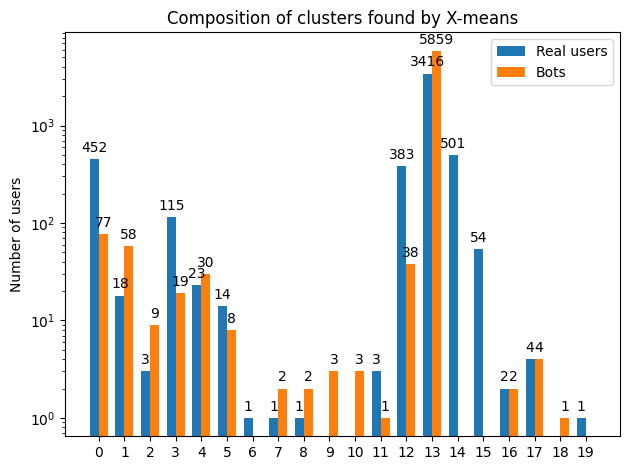

In [14]:
def plot_clusters_compositions(clusters_ids, number_users_per_cluster, number_bots_per_cluster):
    labels = clusters_ids
    number_users_per_cluster = number_users_per_cluster
    number_bots_per_cluster = number_bots_per_cluster

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, number_users_per_cluster, width, label='Real users', log=True)
    rects2 = ax.bar(x + width/2, number_bots_per_cluster, width, label='Bots', log=True)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of users')
    ax.set_title('Composition of clusters found by X-means')
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

is_bot = lambda index: users_df.iloc[index].bot == 1
clusters_ids = []
number_users_per_cluster = []
number_bots_per_cluster = []
for (cluster_index, indexes_in_cluster) in enumerate(clusters):
    number_real_users = 0
    number_bots = 0
    for user_index in indexes_in_cluster:
        if is_bot(user_index):
            number_bots += 1
        else:
            number_real_users += 1
    clusters_ids.append(cluster_index)
    number_users_per_cluster.append(number_real_users)
    number_bots_per_cluster.append(number_bots)
   
plot_clusters_compositions(clusters_ids,number_users_per_cluster, number_bots_per_cluster)

In [71]:
def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

labels = [
    get_element_cluster(index, clusters)
    for index in range(len(users_df))
]

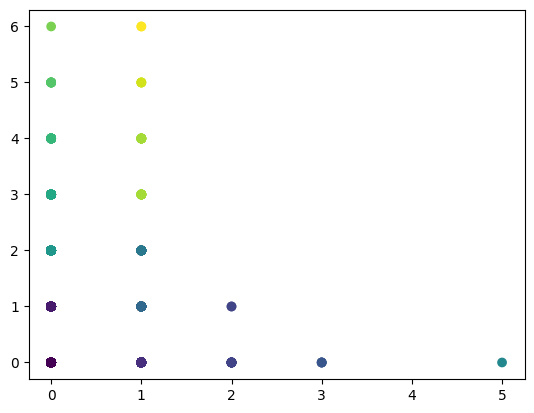

In [73]:
plt.scatter(data=users_df, x=combination[1], y=combination[0],c=labels)

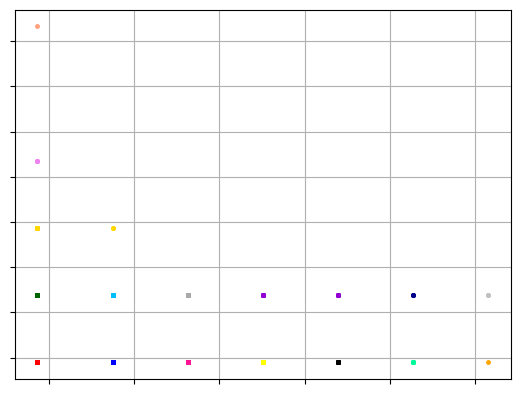

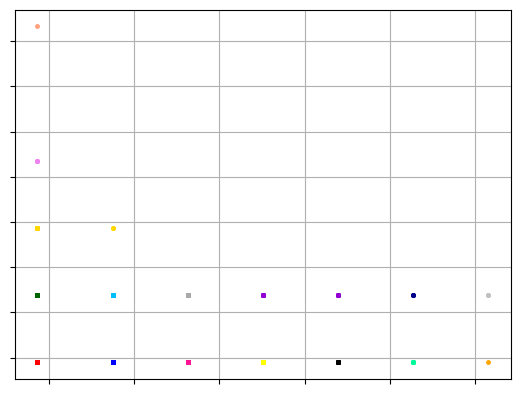

In [55]:
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, transform_result)
visualizer.show()

In [56]:
print("Total WCE:", xmeans_instance.get_total_wce())

Total WCE: 26.334354128113663


In [47]:
%%time
sse = []
for combination in all_possible_combinations:
    subset_df = users_df[list(combination)]
    scaler = StandardScaler()
    scaler.fit(subset_df.values)
    transform_result = scaler.fit_transform(subset_df.values)
    initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
    xmeans_instance = xmeans(transform_result, initial_centers, 20)
    xmeans_instance.process()
    sse.append((combination, xmeans_instance.get_total_wce()))

CPU times: user 50.1 s, sys: 3.32 s, total: 53.4 s
Wall time: 52.4 s


In [48]:
sse.sort(key=lambda x: x[1])

In [49]:
sse[0]

(('account_average_tweets_per_day', 'avg_mentions'), 29.029996676660723)